# Ramp-up Kaggle  - House Prices

### Intro
The this kernel is to get acquainted with Kaggle & experiment with eda, feature engineering & pipelining. 
1st I will test the main regression models & check how they perform
2nd I will experiment with feature selection & see how it impacts performances
3d I will go back & incrementally add pre-processing.

Yes, there is not much logic in my logic...so what???

Many thanks to the guys in the credits for their great kernels!

### Credits
* [House Prices EDA](https://www.kaggle.com/dgawlik/house-prices-eda) by Dominik Gawlik

* [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Julien Cohen-Solal

* [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
#import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#warnings.filterwarnings('ignore')

## Load the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Outliers
We are dealing with house prices. I will look 1st how properties are distributed against sales prices.

I am going to use LotArea (Lot size in square feet) instead of GrLivArea (Above grade (ground) living area square feet) as GrLivArea includes just the house & not the rest, like ground, garages etc...
See the following articles for reference:
https://definedterm.com/above_grade_living_area_total_square_feet
http://www.findwell.com/blog/selling-a-home/how-much-does-lot-size-impact-the-price-of-my-home/

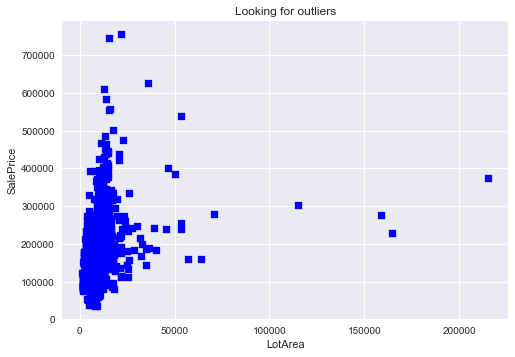

In [3]:
plt.scatter(train.LotArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [4]:
#Let's exclude properties larger than 50K sqrt feet.
train = train[train.LotArea < 5000]

## Preprocessing - Incremental - Step 1

- transform the skewed numeric features by taking log(feature + 1)    
- Create Dummy variables for the categorical features  
- Fill in missed values
- Replace the numeric missing values (NaN's) with the mean of their respective columns

### Target price

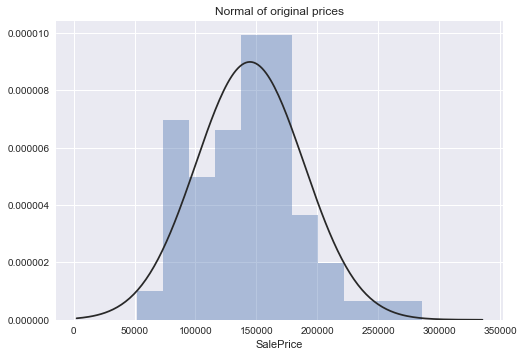

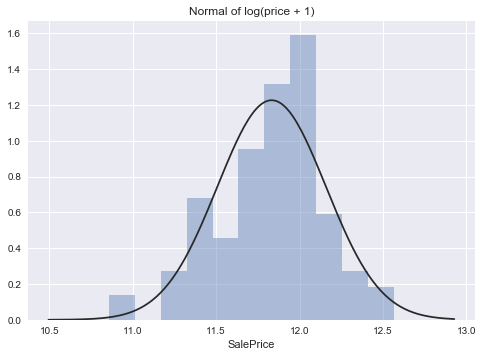

In [5]:
y = train['SalePrice']
plt.figure(1); plt.title('Normal of original prices')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(2); plt.title('Normal of log(price + 1)')
y = np.log1p(train["SalePrice"])
sns.distplot( y, kde=False, fit=stats.norm)
# Drop Id & sales price columns
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
train.drop("SalePrice", axis = 1, inplace = True)
#test.drop("Id", axis = 1, inplace = True)

Taking the log of the target value clearly reduces skewedness

### Missed Values

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1601, 79)


In [7]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.812617
MiscFeature,96.814491
Alley,91.630231
Fence,81.261711
FireplaceQu,51.093067
LotFrontage,15.677701
GarageYrBlt,5.746408
GarageCond,5.746408
GarageQual,5.746408
GarageFinish,5.746408


In [8]:
# PoolQC : data description says NA means "no pool"
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("No")
all_data.loc[:, "PoolArea"] = all_data.loc[:, "PoolArea"].fillna(0)

# MiscFeature : data description says NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("No")
#No extra feature = value of the extra feature is O
all_data.loc[:, "MiscVal"] = all_data.loc[:, "MiscVal"].fillna(0)

# Alley : data description says NA means "no alley access"
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("No")

# Fence : data description says NA means "no Fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("No")

# FireplaceQu : data description says NA means "no FireplaceQu"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("No")
all_data.loc[:, "Fireplaces"] = all_data.loc[:, "Fireplaces"].fillna(0)

#LotFrontage - It means that the property is not visible from the street as it is in a back lo
# see the following interesting discussion on Zillow - 
#https://www.zillow.com/advice-thread/How-to-value-a-home-with-no-street-frontage/325833/
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#GarageType,GarageCond,GarageFinish,GarageQual,GarageCars,GarageArea
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("No")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("No")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageCars"] = all_data.loc[:, "GarageCars"].fillna(0)
all_data.loc[:, "GarageArea"] = all_data.loc[:, "GarageArea"].fillna(0)
all_data.loc[:, "GarageYrBlt"] = all_data.loc[:, "GarageYrBlt"].fillna(0)

# BsmtQual etc : data description says NA for basement features is "no basement"
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("No")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("No")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("No")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("No")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("No")
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data.loc[:, "BsmtUnfSF"] = all_data.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA \means No
all_data.loc[:, "CentralAir"] = all_data.loc[:, "CentralAir"].fillna("N")
# Condition : NA means Normal
all_data.loc[:, "Condition1"] = all_data.loc[:, "Condition1"].fillna("Norm")
all_data.loc[:, "Condition2"] = all_data.loc[:, "Condition2"].fillna("Norm")

#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#MasVnrArea,MasVnrType
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)

#Electrical - fill with the most common value = SBrkr standard Circuit Breakers & Romex
all_data.loc[:, "Electrical"] = all_data.loc[:, "Electrical"].fillna("SBrkr")
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [9]:
#re-check what is still missed
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


### Encoding & normalizing

In [10]:
#Transforming some numerical variables that are really categorical
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [11]:
#Label Encoding some categorical variables that may contain information in their ordering set
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [12]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [13]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print ("#quantitative" , len(quantitative))
print ("#qualitative" , len(qualitative))

#quantitative 36
#qualitative 43


### reduce quantitative variables skewedness

In [14]:
from scipy.stats import skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,21.141888
MiscVal,21.009674
LowQualFinSF,16.769963
3SsnPorch,13.116980
LandSlope,4.982850
EnclosedPorch,4.774880
KitchenAbvGr,4.465408
BsmtFinSF2,4.152563
BsmtHalfBath,3.920066
ScreenPorch,3.869158


In [15]:
#reduce skewedness
from scipy.stats import skew

quantitative_idx = train.dtypes[train.dtypes != "object"].index

#calculate skewedness
skewed_quant = train[quantitative_idx].apply(lambda x: skew(x.dropna()))
skewed_quant = skewed_quant[skewed_quant > 0.75]
skewed_quant = skewed_quant.index
train[skewed_quant] = np.log1p(train[skewed_quant] )
test[skewed_quant] = np.log1p(test[skewed_quant] )

In [16]:
# Create dummy features for categorical values via one-hot encoding
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(1601, 206)


In [17]:
#re-split train & test data
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling 

target is to check how liner models perform & how to improve them:
- run linear models against the current data set & check results 
- reduce variables & check results 


In [18]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#define the scoring model . Using 10 folds cross-validation
def rmse_cv(model,X,y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [19]:
#run ridge
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
cv_ridge_base = [rmse_cv(Ridge(alpha = alpha),train,y).mean() 
            for alpha in alphas]

Best alpha: 30.0 Score: 0.10221


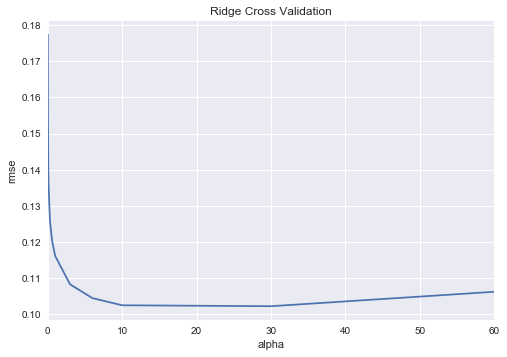

In [20]:
from sklearn import linear_model, metrics
cv_ridge_base = pd.Series(cv_ridge_base, index = alphas) 
cv_ridge_base.plot(title = "Ridge Cross Validation") 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
print ("Best alpha: %s Score: %.5f" % (cv_ridge_base.idxmin(),cv_ridge_base.min()))
best_alpha = cv_ridge_base.idxmin()

In [21]:
#Re-center alphas around the best alpha
bal_alphas = best_alpha * np.array(alphas)
cv_ridge_bal = [rmse_cv(Ridge(alpha = alpha),train,y).mean() 
            for alpha in bal_alphas]

Best alpha: 18.0 Score: 0.10148


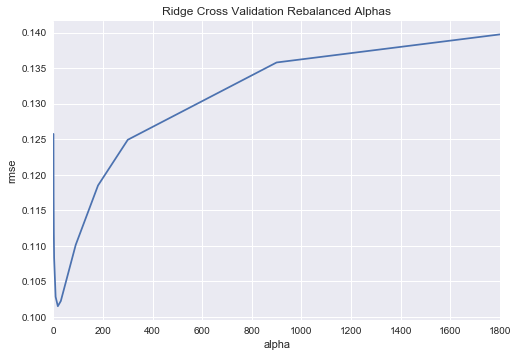

In [22]:
cv_ridge_bal = pd.Series(cv_ridge_bal, index = bal_alphas) 
cv_ridge_bal.plot(title = "Ridge Cross Validation Rebalanced Alphas") 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
print ("Best alpha: %s Score: %.5f" % (cv_ridge_bal.idxmin(),cv_ridge_bal.min()))

In [23]:
# check RidgeCV results. Shit! different that cross_val_score
from sklearn import metrics
ridgeCV = RidgeCV(alphas = alphas, cv=10)
ridgeCV.fit(train, y)
best_alpha = ridgeCV.alpha_
ridgeCV_RMSE = np.sqrt(metrics.mean_squared_error(ridgeCV.predict(train),y))
print ("Best alpha: %s RMSE: %.5f" % (ridgeCV.alpha_,ridgeCV_RMSE))

Best alpha: 10 RMSE: 0.06001


### Feature Selection

Let's 1st have a look at to which features Ridge has given more importance

Ridge picked 141 features and eliminated the other 65 features


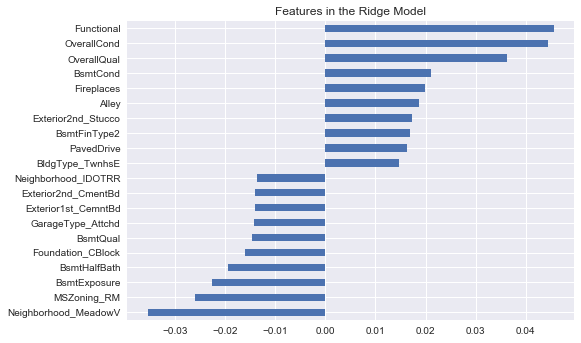

In [24]:
coefs = pd.Series(ridgeCV.coef_, index = train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Features in the Ridge Model")
plt.show()

#### Use random forest to select features

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, random_state=101)
rf.fit(train,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=101, verbose=0, warm_start=False)

Random Forest picked 22 features and eliminated the other 206 features


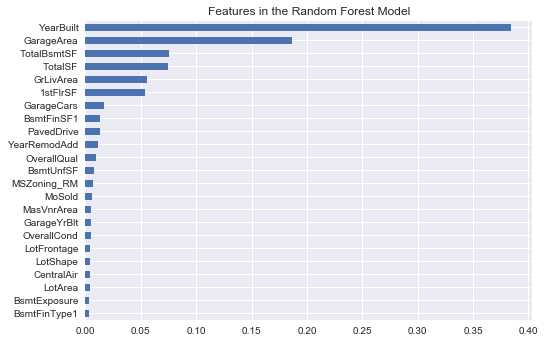

In [26]:
#find the 95% important features
def feature_95(feature_imp):
    sum95 = 0
    for i in range(len(feature_imp)):
        sum95 += feature_imp[i]
        if sum95 >= 0.95:
            return i        
        
feature_imp = pd.Series(rf.feature_importances_, index = train.columns).sort_values(ascending = False)
i = 1 + feature_95(feature_imp)

print("Random Forest picked " + str(i) + " features and eliminated the other " +  str(len(feature_imp-i)) + " features")
imp_coefs = pd.concat([feature_imp[:i+1].sort_values()])
imp_coefs.plot(kind = "barh")
plt.title("Features in the Random Forest Model")
plt.show()

#### Now use the features selected by Random Forest to run Ridge with base alphas

In [27]:
rf_features = feature_imp[:i+1].index
rf_train = train[rf_features]

In [28]:
ridgeCVrf = RidgeCV(alphas = alphas, cv=10)
ridgeCVrf.fit(rf_train, y)
best_alpha = ridgeCVrf.alpha_
ridgeCVrf_RMSE = np.sqrt(metrics.mean_squared_error(ridgeCVrf.predict(rf_train),y))
print ("Best alpha: %s RMSE: %.5f" % (best_alpha,ridgeCVrf_RMSE))

Best alpha: 6 RMSE: 0.09033


Uhm, it seems that this way the Random Forest is not improving Ridge

### Let's use the random forest regressor with CV & see what it does

In [29]:
rf = RandomForestRegressor(n_estimators=300, random_state=101)

cv_rf = rmse_cv(rf,train,y).mean() 
print ("RandomForestRegressor -> cross validation RMSE:  = %0.3f" % cv_rf)

RandomForestRegressor -> cross validation RMSE:  = 0.118


### Submssion nr.2 - RoandomForest + RidgeCV - 50 up 

In [30]:
test_rf = test[rf_features]
len(test_rf.columns)

23

In [31]:
y_test =  ridgeCVrf.predict(test_rf)
submissionHPGR = pd.DataFrame({'Id': test_ID, 'SalePrice': np.exp(y_test)})
# you could use any filename. We choose submission here
submissionHPGR.to_csv('submission_kaggle_house_prices_3ndWrangle.csv', index=False)

### Submssion nr.4 - Stacking 

In [32]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
import lightgbm as lgb

In [33]:
#Averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [34]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [35]:
#define models for averaging & stacking
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [36]:
#redefine the scoring function
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [37]:
#average models
averaged_models = AveragingModels(models = (ENet,model_lgb, KRR, lasso,GBoost))

score = rmse_cv(averaged_models,train,y)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

 Averaged base models score: 0.1315 (0.0366)



In [38]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [39]:
#creating predictions
averaged_models.fit(train.values, y)
avg_train_pred = averaged_models.predict(train.values)
avg_pred = np.exp(averaged_models.predict(test.values))
print(rmsle(y, avg_train_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0237833743906


In [40]:
averaged_models.fit(rf_train.values, y)
avg_train_pred_rf = averaged_models.predict(rf_train.values)
avg_pred_rf = np.exp(averaged_models.predict(test_rf.values))
print(rmsle(y, avg_train_pred_rf))

0.0397301605923


In [41]:
model_lgb.fit(rf_train, y)
lgb_train_pred = model_lgb.predict(rf_train.values)
lgb_pred = np.exp(model_lgb.predict(test_rf.values))
print(rmsle(y, lgb_train_pred))

0.0232821675438


In [42]:
GBoost.fit(rf_train, y)
GBoost_train_pred = GBoost.predict(rf_train.values)
GBoost_pred = np.exp(GBoost.predict(test_rf.values))
print(rmsle(y, GBoost_train_pred))

0.0141260055148


In [43]:
ridgeCVrf_train_pred = ridgeCVrf.predict(rf_train)
ridgeCVrf_pred = np.exp(ridgeCVrf.predict(test_rf))
print(rmsle(y, ridgeCVrf_train_pred))

0.0903301585043


In [44]:
y_test =  ridgeCVrf.predict(test_rf)
submissionHPGR = pd.DataFrame({'Id': test_ID, 'SalePrice': np.exp(y_test)})
# you could use any filename. We choose submission here
submissionHPGR.to_csv('submission_kaggle_house_prices_3ndWrangle.csv', index=False)

In [45]:
#Average the results
ensemble = ridgeCVrf_pred*0.20  + avg_pred_rf * 0.20 + lgb_pred*0.20+avg_pred_rf*0.40

In [46]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y,ridgeCVrf_train_pred*0.20 + GBoost_train_pred*0.4 + lgb_train_pred*0.4 ))

RMSLE score on train data:
0.0270148161607


In [47]:
#submission
submissionHPGR = pd.DataFrame({'Id': test_ID, 'SalePrice': ensemble})
# you could use any filename. We choose submission here
submissionHPGR.to_csv('submission_kaggle_house_prices_9thhWrangle.csv', index=False)

In [47]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),meta_model = lasso)

score = rmse_cv(stacked_averaged_models,train,y)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

KeyError: '[  1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19\n  20  22  23  24  25  26  27  30  33  34  35  36  37  38  39  40  41  42\n  43  44  45  46  48  49  50  51  52  53  54  55  56  58  61  62  63  64\n  65  66  68  69  72  75  76  77  78  79  80  81  82  83  84  85  86  87\n  88  89  91  92  93  96  98 100 101 102 104 105 106 107 108 109 111 112\n 113 115 116 117 119 120 121 122 123 124 126] not in index'